In [1]:
%matplotlib inline

import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.linear_model
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn_pandas import DataFrameMapper
import warnings

matplotlib.style.use('ggplot')

In [2]:
facebook_data = pandas.read_csv('./facebook_train.csv')
facebook_data.head()

,total_followers,type,category,month,weekday,hour,paid,comment,like,share
0,124050,Photo,3,6,4,17,1,3,77,16
1,132556,Photo,2,8,3,24,0,11,313,50
2,92786,Photo,2,2,6,17,1,2,145,39
3,135632,Photo,1,9,2,1,0,2,299,49
4,139540,Link,1,12,3,17,1,7,229,21


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f3dce10>]], dtype=object)

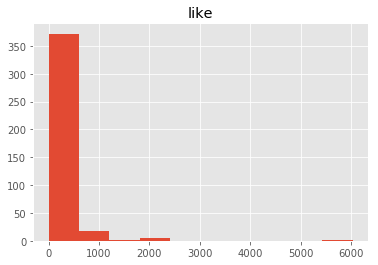

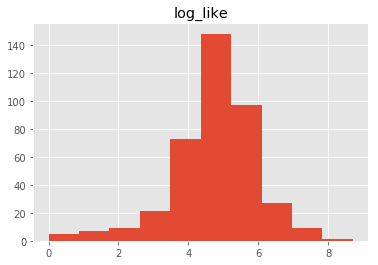

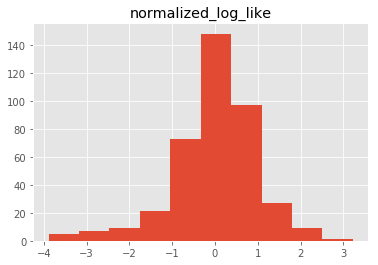

In [3]:
facebook_data.hist('like')

facebook_data['log_like'] = np.log(facebook_data.like + 1)
facebook_data.hist(column='log_like')

facebook_data['normalized_log_like'] = (facebook_data.log_like - np.average(facebook_data.log_like)) / np.std(facebook_data.log_like)
# sklearn.preprocessing.normalize(facebook_data.log_like.as_matrix().reshape(1, -1))[0]
facebook_data.hist(column='normalized_log_like')


In [4]:
np.random.seed(33)

test_indices = np.random.choice(range(len(facebook_data)), 50, replace=False)
train_indices = np.setdiff1d(range(len(facebook_data)), test_indices)

data_test = facebook_data.iloc[test_indices, :]
data_train = facebook_data.iloc[np.setdiff1d(range(len(facebook_data)), test_indices), :]
data_train.shape, data_test.shape

((347, 12), (50, 12))

In [5]:
data_mapper = DataFrameMapper([
    (['total_followers'], sklearn.preprocessing.StandardScaler()),
    ('type', sklearn.preprocessing.LabelBinarizer()),
    (['category'], sklearn.preprocessing.OneHotEncoder()),
    (['month'], sklearn.preprocessing.OneHotEncoder()),
    (['weekday'], sklearn.preprocessing.OneHotEncoder()),
    ('hour', None),
    ('paid', None),
    (['comment'], sklearn.preprocessing.StandardScaler()),
#    ('like', None),
    (['share'], sklearn.preprocessing.StandardScaler())
])

transformed_data = data_mapper.fit_transform(facebook_data.copy())
transformed_data.shape

/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


(397, 31)

In [6]:
# facebook_data.groupby('hour').mean()

In [16]:
from sklearn.cross_validation import cross_val_score

np.random.seed(33)

pipe = sklearn.pipeline.Pipeline([
    ('featurize', data_mapper),
    ('select', sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression)),
    ('lm', sklearn.linear_model.RidgeCV())])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for k in range(3, 16):
        pipe.set_params(select__k=k)
        shuffled = data_train.sample(frac=1)
        cv_scores = np.round(cross_val_score(pipe, X=shuffled, y=shuffled.like, scoring='r2', cv=7), 3)
        print (k, np.average(cv_scores), cv_scores)

3 0.623857142857 [ 0.402  0.849  0.296  0.738  0.674  0.693  0.715]
4 0.696142857143 [ 0.79   0.723  0.466  0.766  0.607  0.761  0.76 ]
5 0.518714285714 [ 0.862  0.464  0.694  0.801 -0.238  0.331  0.717]
6 0.707 [ 0.733  0.704  0.796  0.807  0.591  0.617  0.701]
7 0.631714285714 [ 0.881  0.774  0.178  0.503  0.725  0.688  0.673]
8 0.684857142857 [ 0.817  0.611  0.667  0.571  0.779  0.747  0.602]
9 0.649 [ 0.7    0.558  0.521  0.585  0.818  0.539  0.822]
10 0.628 [ 0.787  0.706  0.717  0.611  0.369  0.685  0.521]
11 0.648428571429 [ 0.301  0.549  0.888  0.605  0.696  0.768  0.732]
12 0.651571428571 [ 0.633  0.848  0.659  0.642  0.784  0.342  0.653]
13 0.618714285714 [ 0.483  0.616  0.658  0.645  0.765  0.811  0.353]
14 0.605571428571 [ 0.72   0.755  0.658  0.658  0.752  0.552  0.144]
15 0.705285714286 [ 0.925  0.635  0.76   0.693  0.625  0.604  0.695]


In [18]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics

optimal_k = 6
pipe.set_params(select__k=optimal_k)
shuffled = data_train.sample(frac=1)
pipe.fit(shuffled, shuffled.like)

test_predictions = pipe.predict(data_test)

for metric in (metrics.mean_squared_error, metrics.mean_absolute_error, 
               metrics.median_absolute_error, metrics.r2_score): 
    print(metric.__name__, metric(test_predictions, data_test.like))

mean_squared_error 41876.1826152
mean_absolute_error 76.6530416009
median_absolute_error 37.1747873914
r2_score 0.959872239691


/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [14]:
facebook_test_data = pandas.read_csv('./facebook_train.csv')
facebook_test_data['log_like'] = np.log(facebook_data.like + 1)
facebook_test_data['normalized_log_like'] = (facebook_test_data.log_like - np.average(facebook_test_data.log_like)) / np.std(facebook_test_data.log_like)

facebook_test_data.head()

,total_followers,type,category,month,weekday,hour,paid,comment,like,share,log_like,normalized_log_like
0,124050,Photo,3,6,4,17,1,3,77,16,4.356709,-0.329601
1,132556,Photo,2,8,3,24,0,11,313,50,5.749393,0.808590
2,92786,Photo,2,2,6,17,1,2,145,39,4.983607,0.182740
3,135632,Photo,1,9,2,1,0,2,299,49,5.703782,0.771314
4,139540,Link,1,12,3,17,1,7,229,21,5.438079,0.554164


In [20]:
new_test_predictions = pipe.predict(facebook_test_data)

for metric in (metrics.mean_squared_error, metrics.mean_absolute_error, 
               metrics.median_absolute_error, metrics.r2_score): 
    print(metric.__name__, metric(new_test_predictions, facebook_test_data.like))

mean_squared_error 27673.4956137
mean_absolute_error 84.359067244
median_absolute_error 39.9487021339
r2_score 0.854382173293


/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
